# Using python to mimic FORTRAN CJ code

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing, os, sys, cProfile, pstats, io, traceback, time, random
from scipy.integrate import quad
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from matplotlib.ticker import LogLocator
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from functools import lru_cache
from joblib import Parallel, delayed
import warnings
from numba import jit, cuda 
from collections import defaultdict
from matplotlib.animation import FuncAnimation
warnings.filterwarnings("ignore")

# Reading the input file

In [2]:
filepath = '/Users/AbSir/Desktop/cj22/CJ-code/fitpack/nucl/phi.wbarel_AV18'
gamma_list = []
y_list = []
f2_list = []
f0_list = []
with open(filepath, 'r') as file:
    for line in file:
        try:
            columns = [float(col) for col in line.split()]
            if len(columns) == 8:
                gamma_list.append(columns[0])
                y_list.append(columns[1])
                f2_list.append(columns[6])
                f0_list.append(columns[2])
        except:
            continue
gamma_array = np.array(gamma_list)
y_array = np.array(y_list)
f2_array = np.array(f2_list)
f0_array = np.array(f0_list)

# Performing the interpolation

Text(0.5, 1.0, 'f0 for Various $\\gamma$ Values')

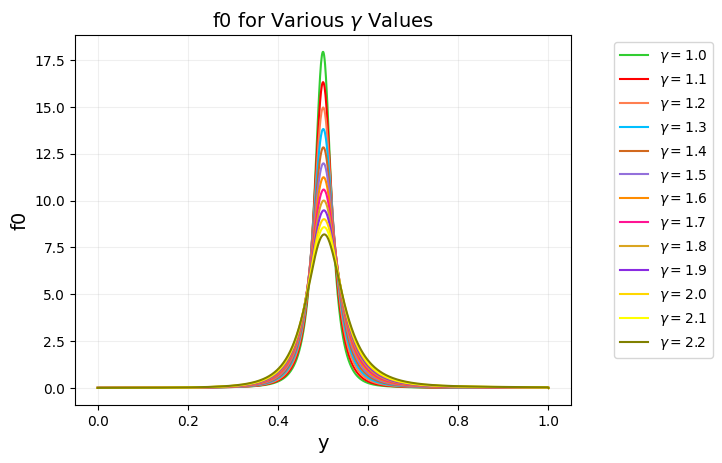

In [3]:
def phi_int2d_fixed_gamma(y_D, gamma_fixed):
    # Find the indices of the gamma values that are equal to the fixed gamma value
    mask = gamma_array == gamma_fixed
    y_filtered = np.array(y_array[mask])
    f2_filtered = np.array(f2_array[mask])
    f0_filtered = np.array(f0_array[mask])
    # y_filtered = 0.5 * y_filtered

    # Perform 1D interpolation along the y axis for the fixed gamma value
    interpolator = interp1d(y_filtered, f0_filtered, kind = 'linear', fill_value = 'extrapolate')

    # Interpolate at the given y value
    result = interpolator(y_D)

    return result

y_D = np.linspace(0, 1, 1000)
f2_1p0 = phi_int2d_fixed_gamma(y_D, 1.0)
f2_1p1 = phi_int2d_fixed_gamma(y_D, 1.1)
f2_1p2 = phi_int2d_fixed_gamma(y_D, 1.2)
f2_1p3 = phi_int2d_fixed_gamma(y_D, 1.3)
f2_1p4 = phi_int2d_fixed_gamma(y_D, 1.4)
f2_1p5 = phi_int2d_fixed_gamma(y_D, 1.5)
f2_1p6 = phi_int2d_fixed_gamma(y_D, 1.6)
f2_1p7 = phi_int2d_fixed_gamma(y_D, 1.7)
f2_1p8 = phi_int2d_fixed_gamma(y_D, 1.8)
f2_1p9 = phi_int2d_fixed_gamma(y_D, 1.9)
f2_2p0 = phi_int2d_fixed_gamma(y_D, 2.0)
f2_2p1 = phi_int2d_fixed_gamma(y_D, 2.1)
f2_2p2 = phi_int2d_fixed_gamma(y_D, 2.2)

col2 = ['forestgreen', 'limegreen', 'red', 'coral', 'deepskyblue', 'chocolate', 'mediumpurple', 'darkorange', 'deeppink', 'goldenrod', 'blueviolet', 'gold', 'mediumspringgreen', 'olive', 'yellow', 'greenyellow', 'springgreen', 'turquoise', 'darkslategray', 'blue', 'darkviolet', 'violet', 'fuchsia', 'maroon', 'pink', 'peru', 'black', 'orchid', 'grey', 'wheat', 'darkkhaki', 'cyan', 'lavender', 'indigo', 'plum', 'sienna', 'tan', 'lavenderblush', 'dimgray']

fig, ax = plt.subplots()
# ax.plot(x, f2, color = 'black', label='f0')
ax.plot(y_D, f2_1p0, color = col2[1], label = r'$\gamma = 1.0$')
ax.plot(y_D, f2_1p1, color = col2[2], label = r'$\gamma = 1.1$')
ax.plot(y_D, f2_1p2, color = col2[3], label = r'$\gamma = 1.2$')
ax.plot(y_D, f2_1p3, color = col2[4], label = r'$\gamma = 1.3$')
ax.plot(y_D, f2_1p4, color = col2[5], label = r'$\gamma = 1.4$')
ax.plot(y_D, f2_1p5, color = col2[6], label = r'$\gamma = 1.5$')
ax.plot(y_D, f2_1p6, color = col2[7], label = r'$\gamma = 1.6$')
ax.plot(y_D, f2_1p7, color = col2[8], label = r'$\gamma = 1.7$')
ax.plot(y_D, f2_1p8, color = col2[9], label = r'$\gamma = 1.8$')
ax.plot(y_D, f2_1p9, color = col2[10], label = r'$\gamma = 1.9$')
ax.plot(y_D, f2_2p0, color = col2[11], label = r'$\gamma = 2.0$')
ax.plot(y_D, f2_2p1, color = col2[14], label = r'$\gamma = 2.1$')
ax.plot(y_D, f2_2p2, color = col2[13], label = r'$\gamma = 2.2$')
ax.grid(alpha = 0.2)
ax.set_xlabel('y', fontsize = 14)
# ax.set_xlim(0.6, 1.4)
ax.set_ylabel('f0', fontsize = 14)
# ax.set_yscale('log')
# ax.set_ylim(1e-4, 3e1)
ax.legend(loc = 'upper right', bbox_to_anchor = (1.3, 1.0))
plt.title(r'f0 for Various $\gamma$ Values', fontsize = 14)
# plt.savefig(f'plots/f2_gamma_{time.time():.0f}.pdf', dpi = 300, bbox_inches = 'tight')

# Performing the integration

In [4]:
y_d_values = []
# all_y_d = []
hisaab = defaultdict(list)
x_noter = []

def f2_function(x, y_D):
    k = x / y_D
    return 4 * k**0.7 * (1 - k)**3.5 * (1 + 4 * k) + 0.15 * k**(-0.4) * (1 - k)**9 * (1 + 16 * k)

def f2nxn_function(x):
    x_N = 2 * x # Convert from x_D to x_N
    return 4 * x_N**0.7 * (1 - x_N)**3.5 * (1 + 4 * x_N) + 0.15 * x_N**(-0.4) * (1 - x_N)**9 * (1 + 16 * x_N)

def phi_int2d_fixed_gamma(y_D, gamma_fixed):
    # Find the indices of the gamma values that are equal to the fixed gamma value
    mask = gamma_array == gamma_fixed
    y_filtered = np.array(y_array[mask])
    f0_filtered = np.array(f0_array[mask])

    # Perform 1D interpolation along the y axis for the fixed gamma value
    interpolator = interp1d(y_filtered, f0_filtered, kind = 'linear', fill_value = 'extrapolate')
    # Interpolate at the given y value
    result = interpolator(y_D)

    return result

# Define the product of f2 and f0 for the integrand
def integrand(y_D, x):
    global y_d_values
    y_d_values.append(y_D)
    f0 = phi_int2d_fixed_gamma(y_D, gamma_fixed)
    f2 = f2_function(x, y_D)
    return f2 * f0

# Perform the integration
def integrate_f2_f0(x):
    global y_d_values
    # all_y_d.append(len(y_d_values))
    hisaab[x].append(len(y_d_values))
    hisaab[x].append(y_d_values)
    y_d_values = [] # Clear the list before each integration to avoid mixing values from different calls
    f2dxd, error = quad(integrand, x, 1, args = x, epsabs = 1e-6, epsrel = 1e-6, limit = maxsub)
    # f2dxn = f2dxd / 2 # Getting structure function in terms of nucleon momentum fraction
    f2dxn = f2dxd
    return f2dxn

gamma_fixed = 1.0
xno = 500
maxsub = 21
x = np.linspace(0, 1, xno) # This is x_D
simple_f2_list = [f2nxn_function(x_val) for x_val in x]
integral_result_list = [integrate_f2_f0(x_val) for x_val in x]
ratio = np.array(integral_result_list) / np.array(simple_f2_list)

# Weighting the integral

In [5]:
hisaabw = defaultdict(list)

def weight_function(y_D):
    return y_D * (1 - y_D)  # Example weight function

# Define the modified integrand using importance sampling
def modified_integrand(y_D, x):
    f0 = phi_int2d_fixed_gamma(y_D, gamma_fixed)
    f2 = f2_function(x, y_D)
    w = weight_function(y_D)
    return f2 * f0 / w  # Adjust the integrand

# Define the function to adjust for the weight normalization
def normalized_integrand(y_D, x):
    w = weight_function(y_D)
    return modified_integrand(y_D, x) * w  # Re-adjust the integrand to ensure the integral value remains the same

# Perform the integration
def integrate_f2_f0(x):
    global y_d_values
    hisaabw[x].append(len(y_d_values))
    hisaabw[x].append(y_d_values[:])  # Use a copy of y_d_values
    y_d_values = []  # Clear the list before each integration to avoid mixing values from different calls
    f2dxd, error = quad(normalized_integrand, x, 1, args=(x,), epsabs=1e-6, epsrel=1e-6, limit=maxsub)
    f2dxn = f2dxd  # Getting structure function in terms of nucleon momentum fraction
    return f2dxn

# # Set initial conditions
# gamma_fixed = 1.0
# xno = 500
# maxsub = 21
# x = np.linspace(0, 1, xno)  # This is x_D

# # Perform the integration for each x value
# simple_f2_list = [f2nxn_function(x_val) for x_val in x]
# integral_result_list = [integrate_f2_f0(x_val) for x_val in x]
# ratio = np.array(integral_result_list) / np.array(simple_f2_list)

In [6]:
# print(hisaab.values())
# print(hisaabw.keys())
y_called = []
y_dist = []
for key in hisaab.keys():
    y_called.append(hisaab[key][0])
    y_dist.append(hisaab[key][1])

# print(len(y_dist))

yw_called = []
yw_dist = []
for key in hisaabw.keys():
    yw_called.append(hisaabw[key][0])
    yw_dist.append(hisaabw[key][1])

print(len(yw_called))

# trialkunji = defaultdict(list)
# tjmmcast = ('shraddha kapoor', 'anubhav bassi')
# animalcast = ('anil kapoor', 'bobby deol')
# boxoffice = (150, 2023)
# trialkunji['animal'].append(400)
# trialkunji['tjmm'].append(150)
# trialkunji['animal'].append(animalcast)
# trialkunji['tjmm'].append(tjmmcast)

# elements = []
# for key in trialkunji.keys():
#     elements.append(trialkunji[key][0])

# print(elements)

0


[]
[]
437.43


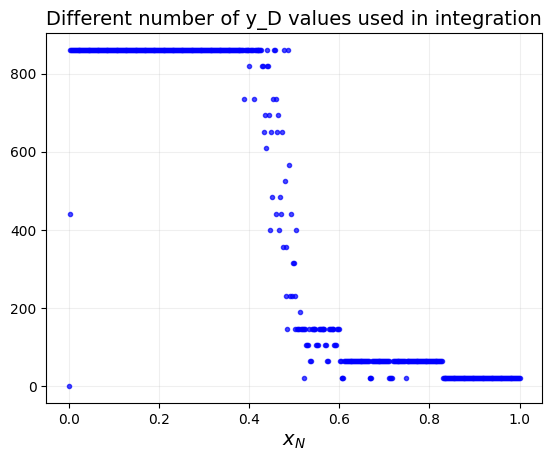

In [7]:
x_called = list(hisaab.keys())
xw_called = list(hisaabw.keys())
print(xw_called)
y_called = np.array(y_called)
yw_called = np.array(yw_called)
print(yw_called)
x_called = np.array(x_called)
xw_called = np.array(xw_called)
plt.plot(x_called, y_called, marker = 'o', markersize = 3, alpha = 0.7, color = 'blue', linestyle = 'None')
# plt.plot(xw_called, yw_called, marker = 'o', markersize = 3, alpha = 0.7, color = 'black', linestyle = 'None')
y_weights = np.ones(len(y_called))
# plt.hist(y_called, bins = 100, weights = y_weights, color = 'blue', alpha = 0.5)
plt.grid(alpha = 0.2)
plt.xlabel(r'$x_N$', fontsize = 14)
# plt.yscale('log')
plt.title('Different number of y_D values used in integration', fontsize = 14)
# plt.savefig(f'plots/y_d_values_{time.time():.0f}.pdf')
# avg_calls = np.mean(y_called)
avg_calls = np.mean(y_called)
print(avg_calls)

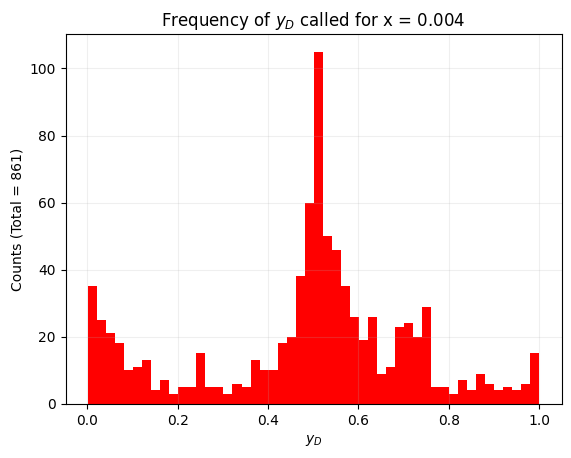

In [8]:
k = 2
plt.hist(y_dist[k], histtype = 'stepfilled', color = 'red', bins = 50)
plt.title(f'Frequency of $y_D$ called for x = {x_called[k]:.3f}')
plt.ylabel(f'Counts (Total = {y_called[k]})')
plt.xlabel('$y_D$')
plt.grid(alpha = 0.2)
# plt.savefig(f'plots/yd_foragivenx_{k}_{time.time():.0f}.pdf')

In [9]:
def integrand(x):
    return x**2
a = 0
b = 1
wvar = (1, 1)  # Example values for the weights
result, error = quad(integrand, a, b, weight = 'alg', wvar = wvar)
# result, error = quad(integrand, a, b)
print("Result of the integration:", result)
print("Estimated error:", error)

Result of the integration: 0.05
Estimated error: 0.0


# Plot it

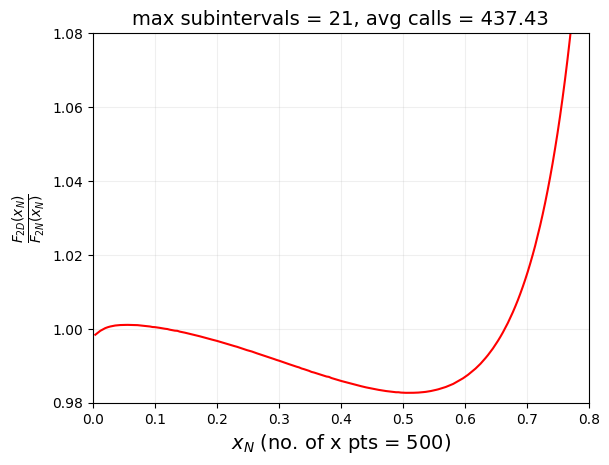

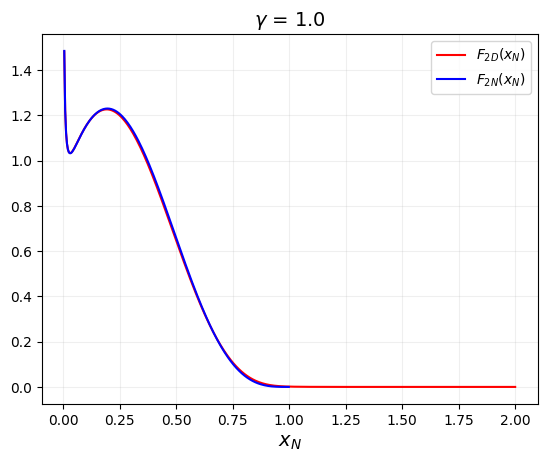

In [10]:
fig3, ax3 = plt.subplots()
x_N = x * 2
ax3.plot(x_N, ratio, 'r')
ax3.grid(alpha = 0.2)
ax3.set_xlabel(fr'$x_N$ (no. of x pts = {xno})', fontsize = 14)
ax3.set_ylabel(r'$\frac{F_{2D}(x_N)}{F_{2N}(x_N)}$', fontsize = 14)
ax3.set_title(fr'max subintervals = {maxsub}, avg calls = {avg_calls}', fontsize = 14)
ax3.set_xlim(0.0, 0.8)
ax3.set_ylim(0.98, 1.08)
# fig3.savefig(f'plots/ratioplot_{time.time()}_{xno}_{maxsub}.pdf')

fig2, ax2 = plt.subplots()
ax2.plot(x_N, integral_result_list, 'r', label = r'$F_{2D}(x_N)$')
ax2.plot(x_N, simple_f2_list, 'b', label = r'$F_{2N}(x_N)$')
ax2.grid(alpha = 0.2)
ax2.set_xlabel(r'$x_N$', fontsize = 14)
ax2.set_title(fr'$\gamma$ = {gamma_fixed}', fontsize = 14)
b = ax2.legend()